# Types of stochastic processes

This notebook describes several stochastic processes of "brownian motion" type.

It is based on the following materials:

- http://www.turingfinance.com/random-walks-down-wall-street-stochastic-processes-in-python/
- http://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-sim-BM.pdf
- https://en.wikipedia.org/wiki/Geometric_Brownian_motion

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-notebook")

In [31]:
class ModelParameters:
    """
    Encapsulates model parameters
    """

    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0,
                 cir_a=0.0, cir_mu=0.0, all_r0=0.0, cir_rho=0.0,
                 ou_a=0.0, ou_mu=0.0,
                 heston_a=0.0, heston_mu=0.0, heston_vol0=0.0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # This is the amount of time to simulate for
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
        # This is the annual drift factor for geometric brownian motion
        self.gbm_mu = gbm_mu
        # This is the probability of a jump happening at each point in time
        self.lamda = jumps_lamda
        # This is the volatility of the jump size
        self.jumps_sigma = jumps_sigma
        # This is the average jump size
        self.jumps_mu = jumps_mu
        # This is the rate of mean reversion for Cox Ingersoll Ross
        self.cir_a = cir_a
        # This is the long run average interest rate for Cox Ingersoll Ross
        self.cir_mu = cir_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0
        # This is the correlation between the wiener processes of the Heston model
        self.cir_rho = cir_rho
        # This is the rate of mean reversion for Ornstein Uhlenbeck
        self.ou_a = ou_a
        # This is the long run average interest rate for Ornstein Uhlenbeck
        self.ou_mu = ou_mu
        # This is the rate of mean reversion for volatility in the Heston model
        self.heston_a = heston_a
        # This is the long run average volatility for the Heston model
        self.heston_mu = heston_mu
        # This is the starting volatility value for the Heston model
        self.heston_vol0 = heston_vol0

In [32]:
model_params = ModelParameters(
    all_s0=1000,
    all_r0=0.5,
    all_time=800,
    all_delta=0.00396825396,
    all_sigma=0.125,
    gbm_mu=0.058,
    jumps_lamda=0.00125,
    jumps_sigma=0.001,
    jumps_mu=-0.2,
    cir_a=3.0,
    cir_mu=0.5,
    cir_rho=0.5,
    ou_a=3.0,
    ou_mu=0.5,
    heston_a=0.25,
    heston_mu=0.35,
    heston_vol0=0.06125
)

paths = 15

## Helper classes

In [33]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    :param log_returns: the log returns to exponentiated
    :return: the exponentiated returns
    """
    return numpy.exp(log_returns)


def convert_to_prices(param, log_returns):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    :param param: the model parameters object
    :param log_returns: the log returns to exponentiated
    :return:
    """
    returns = convert_to_returns(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return numpy.array(price_sequence)

## Plotting

In [38]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    fig = plt.figure()
    plt.title(title)
    plt.xlabel('Time, $t$')
    plt.ylabel('Simulated Price')
    for i in range(len(processes)):
        plt.plot(range(len(processes[0])), processes[i])

## Brownian motion (BM)

This process has the property that the increments are indepent and normally distributed with zero mean and variance equal to the time between increments. It is alwo known as Wiener process. Formally definition is

A stochastic process $\mathbf{B} = \left\{ B(t), t\ge0 \right\}$ is called standard Brownian Motion (BM), if

1. $B(0) = 0$.
2. $\mathbf{B}$ has stationary and independent increments.
3. Increments $B(t) - B(s)$ are random variables with distribution $N(0, t-s)$.

To simulate it at times $0 = t_0 < t_1 < \dots < t_k$:

1. Simulate $k$ independent standard normal variables $Z_i$, $i=1,\dots,k$.
2. Set $B(0) = 0$.
3. Set $B(t_k) = \sum_{i=1}^k \sqrt{\Delta t_i} Z_i$, where $\Delta t_i = t_i - t_{i-1}$.

In [44]:
def generate_brownian_motion(delta_t, nT, s0):
    deltaW = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=nT)
    s = s0 * np.ones(nT+1)
    s[1:] =  s0 + np.cumsum(deltaW)
        
    assert len(s) == nT + 1
    
    return s

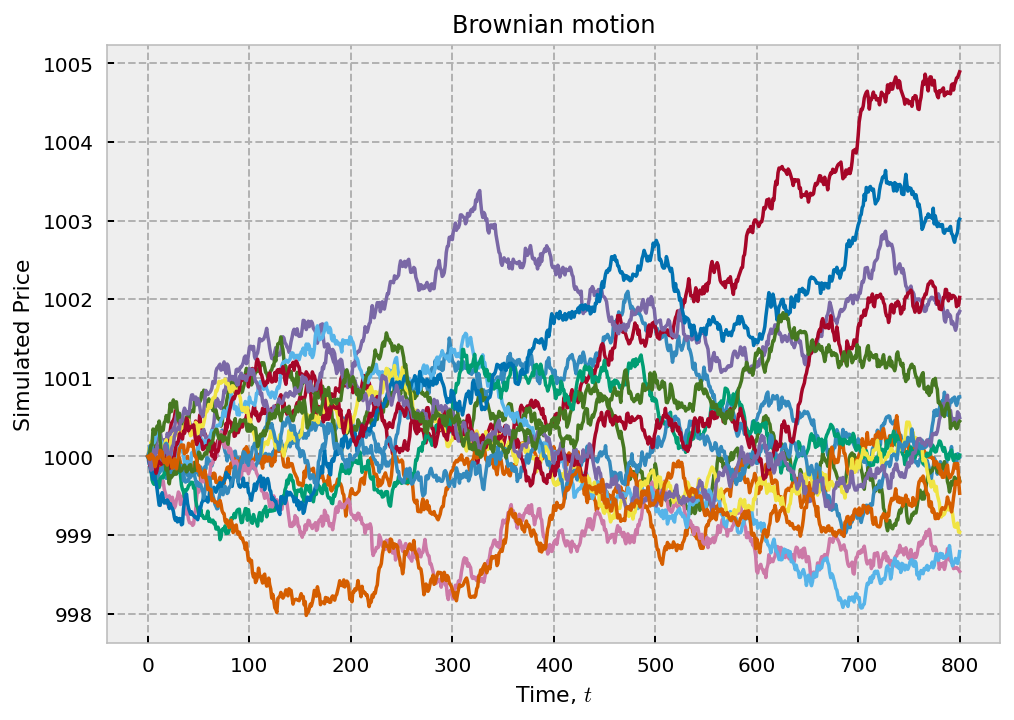

In [46]:
delta_t = 1/252  # This is for dayly changes.
nT = 800  # Number of time steps.
s0 = 1000  # Initial state. It shifts the whole process from zero to the given value.

bm_realizations = []
for i in range(paths):
    bm_realizations.append(generate_brownian_motion(delta_t, nT, s0))
plot_stochastic_processes(brown_motion_realizations, "Brownian motion")

## Brownian motion with drift

It is a process $X(t) = \sigma B(t) + \mu t$, where drift $\mu \in \mathbb R$ and variance $\sigma > 0$:

1. $X(0) = 0$.
2. $\mathbf X$ has stationary independent increments.
3. Increments $X(t) - X(s)$ are random variables with distribution $N\left(\mu (t-s), \sigma^2(t-s)\right)$, where $0 < s < t$.

## Geometric Brownian Motion

Geometric Brownian Motion (GBM, aka exponential BM) is a continuous-time stochastic process $\mathbf S = \left\{ S(t), t \ge 0 \right\}$, in which the logarithm of $S(t)$ follows Brownian motion with drift.

This process was popularized by Black and Scholes in their 1973 paper, where they used GBM process to model stock prices.

This process has drift and diffusion components and follows the following stochastic differential equation:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
where $\mu$ is the percentage drift (expected relative change in price per year), $\sigma$ the percentage volatility of price are constants, $W_t$ the Brownian motion process. Subscripts $t$ denote quantities changing in time.

The first component models deterministic trend, while the second component models unpredictable events occuring in time.

This equation has the following solution:

$$
S_t = S_0 \exp \left( \left(\mu - \frac{\sigma^2}{2} \right)t + \sigma W_t \right)
$$

In [48]:
def generate_geometric_brownian_motion(delta_t, nT, s0, mu, sigma):
    t = np.arange(0, nT+1, 1) * delta_t
    deltaW = np.zeros(nT+1)
    deltaW[1:] = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=nT)
    s =  s0 * np.exp((mu - 0.5*sigma**2)*t + sigma*np.cumsum(deltaW))
        
    assert len(s) == nT + 1
    
    return s

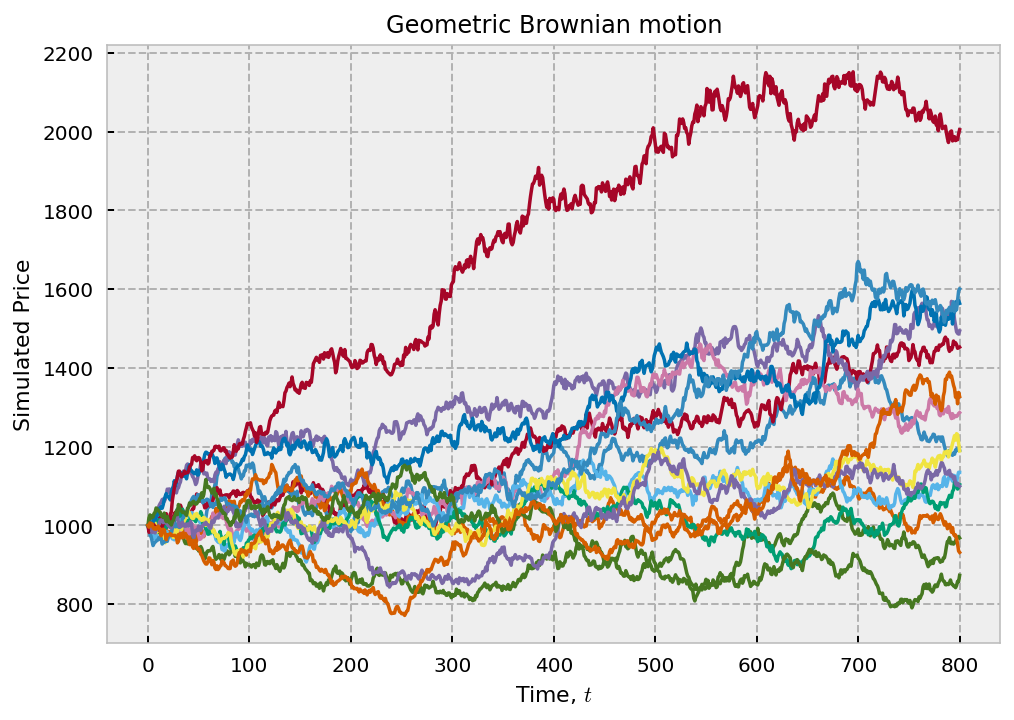

In [62]:
delta_t = 1.0 / 252  # This is for dayly changes.
nT = 800  # Number of time steps.
s0 = 1000  # Initial state. It shifts the whole process from zero to the given value.

gbm_mu = 0.058
gbm_sigma = 0.125

gbm_realizations = []
for i in range(paths):
    gbm_realizations.append(generate_geometric_brownian_motion(delta_t, nT, s0, gbm_mu, gbm_sigma))
plot_stochastic_processes(gbm_realizations, "Geometric Brownian motion")